In [ ]:
#!/usr/bin/env python3
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import os
from math import log

# Notebook Functions

In [32]:
def fetch_gpkg(path:str, epsg:str = '25832') -> gpd.GeoDataFrame:
    """Reads data from geopackage and converts it to specified coordinate reference system.

    Args:
        path (str): path to data
        epsg (str, optional): coordinate reference system. Defaults to '25832'.

    Returns:
        pd.GeoDataFrame: data from file
    """
    df = gpd.read_file(path).to_crs(epsg)
    return df

In [33]:
def combine_inventory(base_inventory, append_inventory, year,
                      sector, sourcetype, unit_factors, append_geometry = False):
    """This function is used to combine the TNO inventory with our inventories. 

    Args:
        tno (GeoDataframe): base inventory (TNO downscaled)
        tum (GeoDataframe): Additional secotor to be added
        year (string): year of the inventory to be combined
        sector (string): GNFR Sector (e.g. F = road transport)
        sourcetype (string): "A" for area sources, "P" for point sources
        append_geometry (Bool): False if no geometry check should be performed. 
        This can be used to append additional geometry or point sources to the inventory.

    Returns:
        GeoDataframe: Combined inventory
    """
    tno = base_inventory
    tum = append_inventory
    
    for component, factor in unit_factors.items():
        tum[component] = tum[component]*factor
    
    if append_geometry:
        tum_comb = tum
    else: 
        tum['geometry'] = tum.centroid
        tum_comb = gpd.sjoin(tno[['id','geometry']].drop_duplicates('geometry'), tum, 
                             how = 'inner').drop('index_right', axis=1).dropna()
        
    tum_comb['Year']=year
    tum_comb['GNFR_Sector']=sector
    tum_comb['SourceType']=sourcetype
    tum_comb['ISO3']='DEU'
    
    combined = pd.concat([tno,tum_comb], ignore_index=True)
    combined = combined.sort_values('id').reset_index(drop=True)
    
    return gpd.GeoDataFrame(combined, geometry = 'geometry') # return as geodataframe

In [34]:
def plot_inventory(df:gpd.GeoDataFrame,
                   component:'str',
                   sector:'str'='sum') -> None:

     fig, ax = plt.subplots(figsize=(10,10))
     
     if sector == 'sum': 
          plot_sum = df.groupby('id').agg({'CO2':lambda x: x.sum()* 1e-3,
                                        'CO2_bio':lambda x: x.sum()* 1e-3, 
                                        'NOX':'sum',
                                        'CO':'sum',
                                        'CH4':'sum', 
                                        'geometry': lambda x: x.iloc[0]})

          gpd.GeoDataFrame(plot_sum, geometry= 'geometry').plot(ax = ax, 
                                                                column = component, 
                                                                cmap = matplotlib.colormaps['PuBu'], 
                                                                scheme = "JenksCaspall",
                                                                vmin = 0,
                                                                k = 7,  
                                                                legend = True)
          
          # plot point sources
          max_value = df[df['GNFR_Sector']=='A'][component].max()
          df['point_size'] = 500*(df['CO2']/max_value)
          df[df['GNFR_Sector']=='A'].plot(ax = ax,
                                          markersize = 100* np.log(df[df['GNFR_Sector']=='A']['point_size']), 
                                          color = 'black')
          
          ax.set_title('Munich CO2 Emissions 2022')
          ax.get_legend().set_title("CO2 [kg/cell/year]")
          ax.set_xlabel('Latitude')
          ax.set_ylabel('Longitude')
          
     else: 
          df[df['GNFR_Sector']==sector].plot(ax = ax, 
                                             column = component, 
                                             cmap = matplotlib.colormaps['PuBu'])
     
     return None

In [35]:
def calculate_sum(df): 
    df = df.groupby('GNFR_Sector').agg({'CO2':'sum',
                                        'CO2_bio':'sum',
                                        'NOX':'sum',
                                        'CO':'sum',
                                        'CH4':'sum', 
                                        'PM': 'sum'})
    df['CO2']= df['CO2']*1e-6 # convert to kt
    df['CO2_bio']= df['CO2_bio']*1e-6 # convert to kt
    df['NOX']= df['NOX']*1e-3 # convert to t
    df['CH4']= df['CH4']*1e-3 # convert to t
    df['CO']= df['CO']*1e-3 # convert to t
    df['PM']= df['PM']*1e-3 # convert to t
    
    # Calculate the sum of each column
    totals = df.sum()

    # Convert the totals to a DataFrame and transpose it
    totals_df = totals.to_frame().T

    # Set the index name for the totals row
    totals_df.index = ['Total']

    # Append the totals row to the DataFrame using pd.concat
    df = pd.concat([df, totals_df])

    return df

# Processing

In [ ]:
# define year of interest
year = '2022'

# define filepaths
data_directory = os.path.dirname(os.path.abspath(''))
tno_path = data_directory + f'/01_input_data/Other Sectors/TNO_GHGco_v4_1_highres_year{year}_Munich.gpkg'
gnfr_a_path = os.path.join(data_directory, '01_input_data', 'GNFR A', year, f'{year}_GNFR_A.gpkg')
gnfr_f_path = os.path.join(data_directory, '01_input_data', 'GNFR F', year, f'{year}_GNFR_F.gpkg')
gnfr_c_path = os.path.join(data_directory, '01_input_data', 'GNFR C', year, f'{year}_GNFR_C.gpkg')
respiration_path = os.path.join(data_directory, '01_input_data', 'Human Respiration', '2019-2024', f'{year}_human_respiration.gpkg') # no differences for different years

assert(os.path.exists(tno_path))
assert(os.path.exists(gnfr_a_path))
assert(os.path.exists(gnfr_f_path))
assert(os.path.exists(gnfr_c_path))
assert(os.path.exists(respiration_path))

# fetch data from geopackages
tno = fetch_gpkg(tno_path)
gnfr_a = fetch_gpkg(gnfr_a_path)
gnfr_f = fetch_gpkg(gnfr_f_path)
gnfr_c = fetch_gpkg(gnfr_c_path)
human_respirantion = fetch_gpkg(respiration_path)

# calculate biogenic CO2 emissions for road transport
gnfr_f['CO2_bio'] = gnfr_f['CO2(total)'] - gnfr_f['CO2(rep)']

# assign human respiration CO2 to biogenic sector
human_respirantion['CO2_bio'] = human_respirantion['CO2'] #HR is the same value in CO2 and CO2_bio since all emissions are biogenic

# rename columns
gnfr_f = gnfr_f.rename(columns = {'CO2(total)' : 'CO2', 'NOx' : 'NOX'})
gnfr_c = gnfr_c.rename(columns = {'NOx' : 'NOX', 'PM10': 'PM'})

In [37]:
# drop bottom up sectors from TNO inventory
bottom_up_sectors = ['A','B','C','F']
tno_red = tno.drop(tno[tno['GNFR_Sector'].isin(bottom_up_sectors)].index, axis = 0)

In [ ]:
# Convert all units to kg / year
gnfr_a_factors = {'CO2':1, 'NOX': 1, 'CO': 1}
combined = combine_inventory(tno_red, gnfr_a, 
                            year, "A", "P", gnfr_a_factors, 
                            append_geometry = True)

gnfr_f_factors = {'CO2':1, 'NOX': 1, 'CO': 1,
                  'PM': 1, 'NO2': 1, 'CH4': 1,
                  'CO2_bio' : 1}
combined = combine_inventory(combined, gnfr_f, 
                           year, "F", "A", gnfr_f_factors)

gnfr_c_factors = {'CO2':1, 'NOX': 1, 'CO': 1, 'PM': 1}
combined = combine_inventory(combined, gnfr_c, 
                            year, "C", "A", gnfr_c_factors)

hr_factors = {'CO2_bio':1}
combined = combine_inventory(combined, human_respirantion, 
                            year, "Hum. Resp.", "A", hr_factors)

combined['Year'] = year

# Export GPKG

In [ ]:
columns_to_keep = ['id', 'ISO3', 'Year', 'GNFR_Sector', 'SourceType',
                   'CO2', 'NOX', 'CO', 'CH4', 'PM', 'CO2_bio', "CO2_residential", "CO2_nonresidential", "CO2_outdoor",
                   'geometry']
inventory = combined[columns_to_keep].copy()

#save_path = data_directory + f'/00_munich_inventory/munich_GHGco_v2_year{year}.gpkg'
#inventory.to_file(save_path, driver = 'GPKG')

# Export XLSX

In [ ]:
columns_to_keep = ['id', 'ISO3', 'Year', 'GNFR_Sector', 'SourceType',
                   'CO2', 'NOX', 'CO', 'CH4', 'PM', 'CO2_bio',
                   'geometry']
inventory = combined[columns_to_keep].copy()
sum_value = calculate_sum(inventory)

rename_dict = {'CO2': 'CO2 [kt]', 'CO2_bio' : 'CO2_bio [kt]'}
for c in ['NOX', 'CO', 'CH4', 'PM']:
    rename_dict.update({c : f'{c} [t]'})

sum_value.rename(columns = rename_dict, inplace=True)
print(sum_value.head(20))
sum_value.to_excel(data_directory + f'/00_munich_inventory/sum_{year}.xlsx')

                CO2 [kt]  CO2_bio [kt]      NOX [t]       CO [t]      CH4 [t]  \
A           2.382400e+03      0.000000  1286.400000    76.915000     0.000000   
C           1.785326e+03      0.000000   681.387079   388.566187     0.000000   
D           4.131733e+01      0.000000     0.000000     0.000000   250.608654   
E           3.450833e+01      0.000000     3.653137   227.871598    14.398407   
F           1.070697e+03     69.951658  1995.915774  2967.303454    53.197062   
G           2.242724e-14      0.000000     0.000000     0.000000     0.000000   
Hum. Resp.  4.459006e+02    445.900627     0.000000     0.000000     0.000000   
I           6.976038e+01      0.000000   270.274595  3046.961317    11.530026   
J           0.000000e+00      0.000000    11.395940     5.048450  1060.466738   
K           0.000000e+00      0.000000     0.000000     0.000000    83.799852   
L           7.845696e-01      0.000000     0.007190     0.208514    16.160823   
Total       5.830695e+03    

In [45]:
inventory.head()

,id,ISO3,Year,GNFR_Sector,SourceType,CO2,NOX,CO,CH4,PM,CO2_bio,geometry
0,97.0,DEU,2022,D,A,1.116205e+02,0.000000,0.000000,0.728119,NaN,NaN,"POLYGON ((675503.470 5336499.375, 675500.627 5..."
1,97.0,DEU,2022,I,A,6.912988e+01,0.633826,0.090053,0.000880,NaN,NaN,"POLYGON ((675503.470 5336499.375, 675500.627 5..."
2,97.0,DEU,2022,E,A,1.214697e+02,0.012859,0.802110,0.050683,NaN,NaN,"POLYGON ((675503.470 5336499.375, 675500.627 5..."
3,97.0,DEU,2022,G,A,7.894411e-14,0.000000,0.000000,0.000000,NaN,NaN,"POLYGON ((675503.470 5336499.375, 675500.627 5..."
4,97.0,DEU,2022,Hum. Resp.,A,6.313847e+01,NaN,NaN,NaN,NaN,63.138471,"POLYGON ((675503.470 5336499.375, 675500.627 5..."


/Users/daniel_tum/Documents/projects/Munich City Inventory D1.2/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/daniel_tum/Documents/projects/Munich City Inventory D1.2/.venv/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


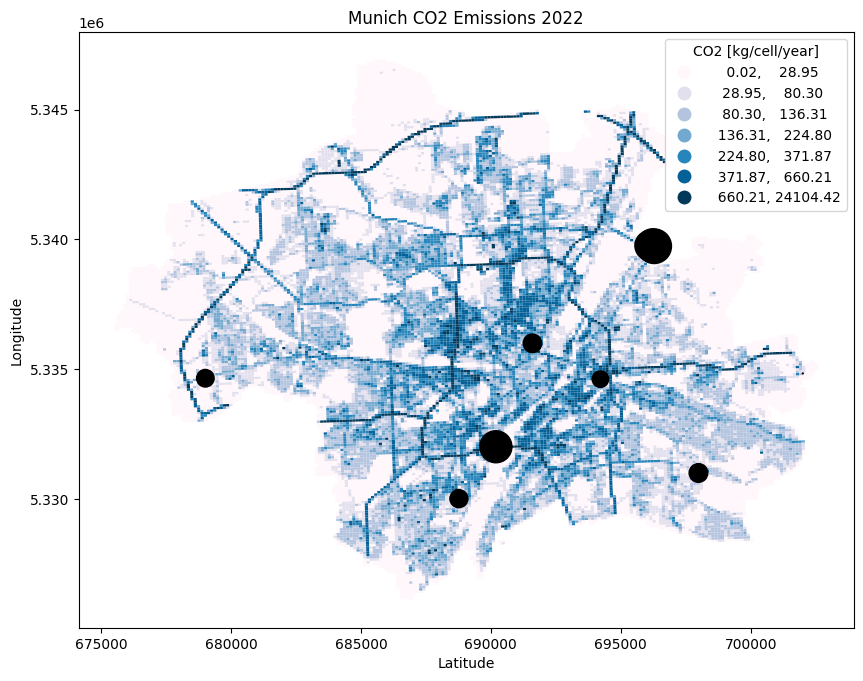

In [46]:
plot_inventory(inventory, 'CO2', sector='sum')